In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

tweets = pd.read_csv('../TP1-Organizacion-de-Datos/csv/train.csv')
tweets.sample(n=5)

,id,keyword,location,text,target
7217,10336,weapons,"California, United States",#Kick Hendrixonfire @'=BLACKCATS= | BIG NOOB ...,0
2553,3661,destroy,NaN,@RaidersReporter @957thegame together we can d...,0
773,1119,blew%20up,"Queens, NY",Lmao that light skin guy blew up on Twitter by...,0
2370,3408,derail,NaN,@EmiiliexIrwin Totally agree.She is 23 and kno...,0
7458,10673,wounds,Alex/Mika/Leo|18|he/she/they,@ego_resolution im glad. My gay can heal 1000 ...,0


In [2]:
tweets_final = tweets.rename(columns={'target':'about_disaster'})
tweets_final['about_disaster'] = ((tweets_final['about_disaster'])==1)
tweets_final.head()

,id,keyword,location,text,about_disaster
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,True
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,True
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,True
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",True
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,True


# Veracidad por keyword

In [3]:
tweets_final['keyword'].fillna("none_keyword", inplace=True)

In [4]:
tweets_por_keyword = tweets_final.groupby(['keyword']).agg({'about_disaster':['sum','count']})
tweets_por_keyword.head()

about_disaster      
                               sum count
keyword                                 
ablaze                        13.0    36
accident                      24.0    35
aftershock                     0.0    34
airplane%20accident           30.0    35
ambulance                     20.0    38

In [5]:
tweets_por_keyword.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222 entries, ablaze to wrecked
Data columns (total 2 columns):
(about_disaster, sum)      222 non-null float64
(about_disaster, count)    222 non-null int64
dtypes: float64(1), int64(1)
memory usage: 5.2+ KB


In [6]:
nivel0 = tweets_por_keyword.columns.get_level_values(0)
nivel1 = tweets_por_keyword.columns.get_level_values(1)
tweets_por_keyword.columns = nivel0 + '_' + nivel1
tweets_por_keyword.head()

,about_disaster_sum,about_disaster_count
keyword,,
ablaze,13.0,36
accident,24.0,35
aftershock,0.0,34
airplane%20accident,30.0,35
ambulance,20.0,38


In [7]:
nuevos_nombres = {'about_disaster_sum':'about_disaster_true', 'about_disaster_count':'count'}
tweets_por_keyword.rename(columns=nuevos_nombres, inplace=True)
tweets_por_keyword.head()

,about_disaster_true,count
keyword,,
ablaze,13.0,36
accident,24.0,35
aftershock,0.0,34
airplane%20accident,30.0,35
ambulance,20.0,38


In [8]:
tweets_por_keyword['about_disaster_false'] = tweets_por_keyword['count'] - tweets_por_keyword['about_disaster_true']
tweets_por_keyword['veracity'] =  tweets_por_keyword['about_disaster_true']/tweets_por_keyword['count']
tweets_por_keyword = tweets_por_keyword[['about_disaster_true', 'about_disaster_false', 'count', 'veracity']]
tweets_por_keyword.sort_values(by='veracity', ascending=False, inplace=True)
tweets_por_keyword.head(10)

,about_disaster_true,about_disaster_false,count,veracity
keyword,,,,
wreckage,39.0,0.0,39,1.000000
derailment,39.0,0.0,39,1.000000
debris,37.0,0.0,37,1.000000
outbreak,39.0,1.0,40,0.975000
typhoon,37.0,1.0,38,0.973684
oil%20spill,37.0,1.0,38,0.973684
suicide%20bombing,32.0,1.0,33,0.969697
suicide%20bomber,30.0,1.0,31,0.967742
bombing,27.0,2.0,29,0.931034


In [9]:
tweets_por_keyword['count'].mean()

34.292792792792795

In [10]:
tweets_por_keyword['count'].value_counts()

35    31
34    30
33    26
36    20
37    19
38    16
32    15
39    14
31     9
29     8
40     7
30     6
41     4
42     2
28     2
27     2
22     1
10     1
11     1
12     1
19     1
61     1
24     1
25     1
26     1
45     1
9      1
Name: count, dtype: int64

In [11]:
keywords_veraces = (tweets_por_keyword[tweets_por_keyword['count']>=29]['veracity']*100).head(20)
keywords_no_veraces = (tweets_por_keyword[tweets_por_keyword['count']>=29]['veracity']*100).tail(20)

Text(0.5, 1.0, 'Top 20 Keywords con mejor porcentaje de veracidad')

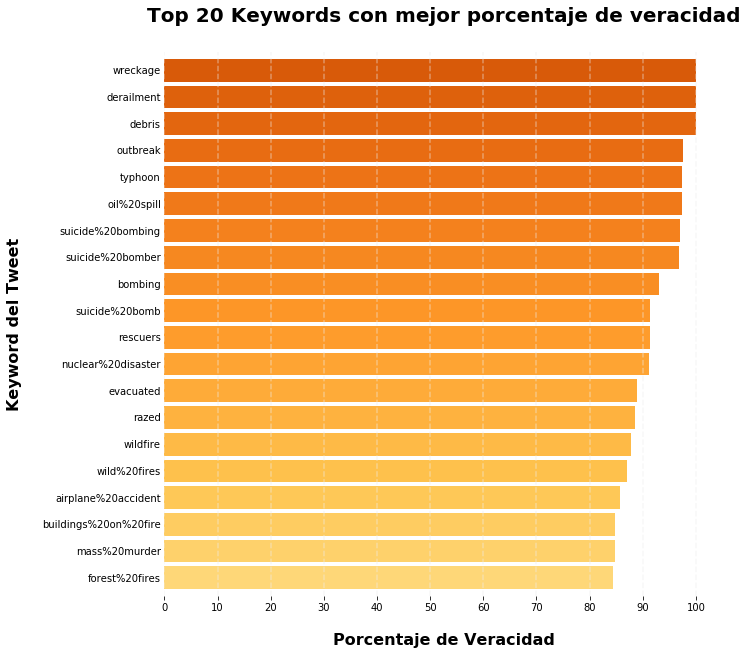

In [12]:
saltos = np.linspace(0.3, 0.7, 20)
colores = (cm.get_cmap('YlOrBr'))(saltos)
top20 = keywords_veraces.sort_values().plot(kind='barh', figsize=(10,10), color=colores, width=0.85)

plt.xticks(np.arange(0, 100+1, 10.0))
plt.tick_params(axis='y', length=0)

top20.spines['right'].set_visible(False)
top20.spines['top'].set_visible(False)
top20.spines['left'].set_visible(False)
top20.spines['bottom'].set_visible(False)

lineas = top20.get_xticks()
for i in lineas:
      top20.axvline(x=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
top20.set_xlabel("Porcentaje de Veracidad", labelpad=20, weight='bold', size=16)
top20.set_ylabel("Keyword del Tweet", labelpad=20, weight='bold', size=16)

plt.title("Top 20 Keywords con mejor porcentaje de veracidad", weight='bold', size=20, pad=30)

Text(0.5, 1.0, 'Top 20 Keywords con peor porcentaje de veracidad')

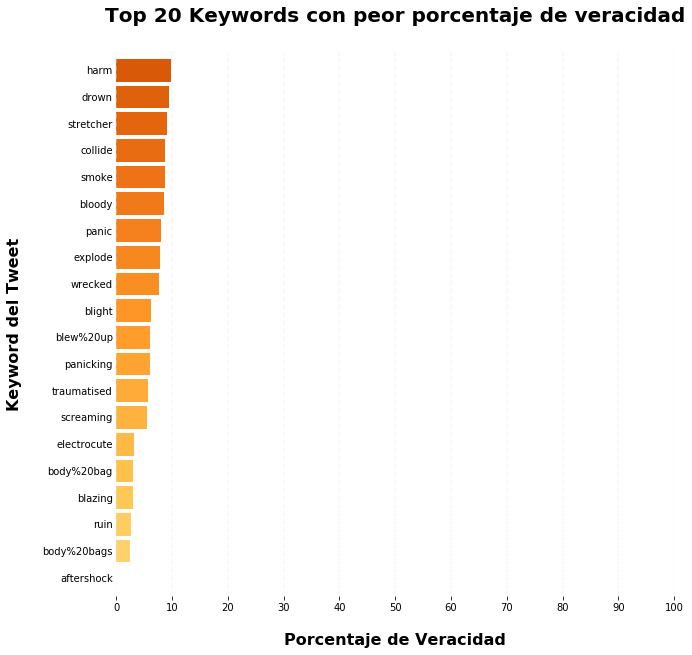

In [13]:
top20 = keywords_no_veraces.sort_values().plot(kind='barh', figsize=(10,10), color=colores, width=0.85)

plt.xticks(np.arange(0, 100+1, 10.0))
plt.tick_params(axis='y', length=0)

top20.spines['right'].set_visible(False)
top20.spines['top'].set_visible(False)
top20.spines['left'].set_visible(False)
top20.spines['bottom'].set_visible(False)

lineas = top20.get_xticks()
for i in lineas:
      top20.axvline(x=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
top20.set_xlabel("Porcentaje de Veracidad", labelpad=20, weight='bold', size=16)
top20.set_ylabel("Keyword del Tweet", labelpad=20, weight='bold', size=16)

plt.title("Top 20 Keywords con peor porcentaje de veracidad", weight='bold', size=20, pad=30)

Text(0.5, 1.0, 'Cantidad de Keywords por porcentaje de veracidad')

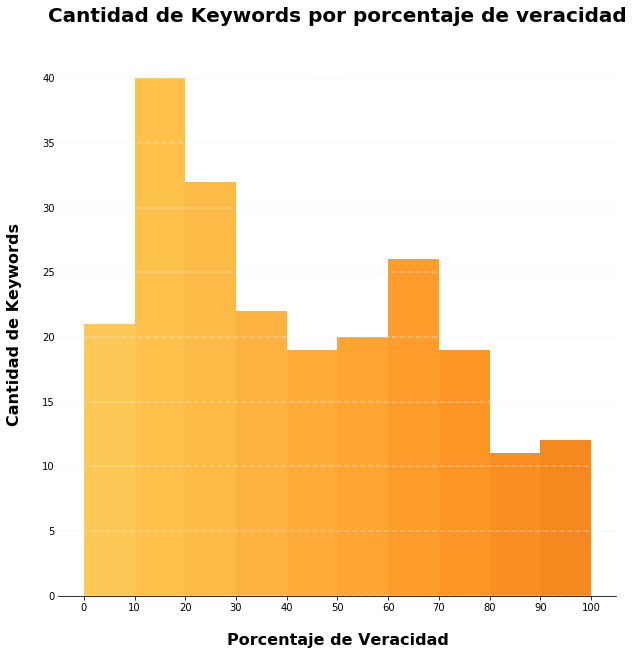

In [33]:
plt.figure(figsize=(10,10))    
n, bins, patches = plt.hist(tweets_por_keyword["veracity"]*100, bins=10, color="c")
hist_porcentajes = plt.gca()

for i,p in enumerate(patches):
    plt.setp(p, "facecolor", colores[i+3])

plt.xticks(np.arange(0, 100+1, 10.0))
plt.yticks(np.arange(0, 40+1, 5.0))
plt.tick_params(axis='y', length=0)

hist_porcentajes.spines['right'].set_visible(False)
hist_porcentajes.spines['top'].set_visible(False)
hist_porcentajes.spines['left'].set_visible(False)

lineas = hist_porcentajes.get_yticks()
for i in lineas:
      hist_porcentajes.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
hist_porcentajes.set_xlabel("Porcentaje de Veracidad", labelpad=20, weight='bold', size=16)
hist_porcentajes.set_ylabel("Cantidad de Keywords", labelpad=20, weight='bold', size=16)

plt.title("Cantidad de Keywords por porcentaje de veracidad", weight='bold', size=20, pad=30)